Beale synthetic function:

GP CBM versus STP nu = 3 CBM (winner)

https://www.sfu.ca/~ssurjano/beale.html

In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc

rc('text', usetex=False)
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
### Inputs:

obj_func = 'Beale'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util_gp = 'CBMinimized'
util_stp = 'tCBMinimized'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [4]:
### Objective function:

if obj_func == 'Beale':
    
    # True y bounds:
    y_lb = 0
    operator = -1 # targets global minimum 
    y_global_orig = y_lb * operator # targets global minimum
            
# Constraints:
    lb = -4.5 
    ub = +4.5

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}
    
# Test data:
    x1_test = np.linspace(lb, ub, n_test)
    x2_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return operator * (
                (1.500 - x1_training + x1_training * x2_training)**2 +
                (2.250 - x1_training + x1_training * x2_training**2)**2 +
                (2.625 - x1_training + x1_training * x2_training**3)**2 
                )
    

In [5]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [7]:
### Set-seeds:

run_num_13 = 13


In [8]:
### Acquisition function - CBM:

class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-06, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'CBMinimized': self.CBMinimized,
            'tCBMinimized': self.tCBMinimized
        }

        self.f = mode_dict[mode]
   
    def CBMinimized(self, tau, mean, std):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
    
    def tCBMinimized(self, tau, mean, std, nu=df):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (std + self.eps) * (gamma + np.sqrt(Beta_CBM))

    def eval(self, y_global_orig, mean, std):
    
        return self.f(y_global_orig, mean, std, **self.params)
        
    def t_eval(self, y_global_orig, mean, std, nu=df):
    
        return self.f(y_global_orig, mean, std, nu=df, **self.params)
    

In [9]:
n_start_AcqFunc = max_iter
inverse = -1


In [10]:
## GPGO_multi: Gaussian

n_start = n_start_AcqFunc

class GPGO_multi(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Min. GP CBM'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.eval(self.tau, new_mean, new_std)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
## GPGO_multi_STP: Student's-t

class GPGO_multi_STP(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Min. STP CBM (nu=3)'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.t_eval(self.tau, new_mean, new_std)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [12]:
### APPROXIMATE GP CBM GRADIENTS: 20 random-multi starts (i.e. 20 rms)

np.random.seed(run_num_13)
surrogate_gp_13 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_13 = GPGO_multi(surrogate_gp_13, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_13.run(max_iter = 1, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. GP CBM
init	 [ 2.4993217  -2.36212902]	 1312.0597023727128	 25.917758071459016	    
init	 [2.91850679 4.19174278]	 48757.43948599124	 25.917758071459016	    
init	 [ 4.25341003 -0.41895677]	 25.917758071459016	 25.917758071459016	    
init	 [0.98138216 2.47973863]	 337.8750512678324	 25.917758071459016	    
init	 [1.2745201  1.99816407]	 177.1374160884886	 25.917758071459016	    
1	 [0.68616841 0.87186966]	 12.072275435399341	 12.072275435399341	 -4.712002818735367


In [13]:
### APPROXIMATE STP CBM GRADIENTS: 20 random-multi starts (i.e. 20 rms)

np.random.seed(run_num_13)
surrogate_stp_13 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_13 = GPGO_multi_STP(surrogate_stp_13, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_13.run(max_iter = 1, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. STP CBM (nu=3)
init	 [ 2.4993217  -2.36212902]	 1312.0597023727128	 25.917758071459016	    
init	 [2.91850679 4.19174278]	 48757.43948599124	 25.917758071459016	    
init	 [ 4.25341003 -0.41895677]	 25.917758071459016	 25.917758071459016	    
init	 [0.98138216 2.47973863]	 337.8750512678324	 25.917758071459016	    
init	 [1.2745201  1.99816407]	 177.1374160884886	 25.917758071459016	    
1	 [-1.3158115   1.32655875]	 3.4642422629217675	 3.4642422629217675	 -28167.594329540265


In [14]:
gp_13_20rms = pd.Series(np.round(gp_13.f_best, 2)).value_counts(sort=True)
gp_13_20rms_df = pd.DataFrame({'Frequency':gp_13_20rms.values,'GP CBM':gp_13_20rms.index})
gp_13_20rms_df


,Frequency,GP CBM
0,16,-2.83
1,2,-0.17
2,2,-4.71


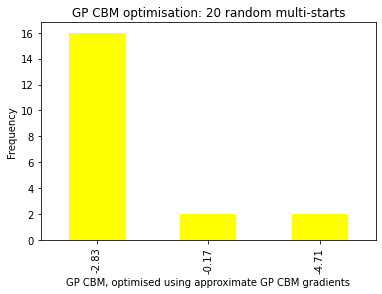

In [15]:
ax = gp_13_20rms.plot.bar(title="GP CBM optimisation: 20 random multi-starts", xlabel="GP CBM, optimised using approximate GP CBM gradients", ylabel="Frequency", color="yellow")


In [16]:
stp_13_20rms = pd.Series(np.round(stp_13.f_best, 2)).value_counts(sort=True)
stp_13_20rms_df = pd.DataFrame({'Frequency':stp_13_20rms.values,'STP CBM':stp_13_20rms.index})
stp_13_20rms_df


,Frequency,STP CBM
0,12,-28162.15
1,5,-28167.59
2,2,-28152.46
3,1,-28162.92


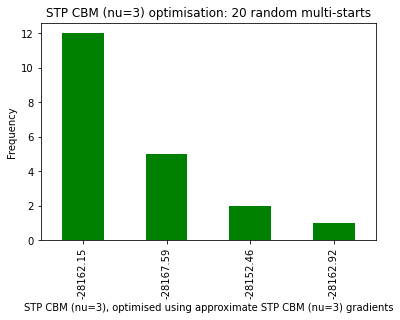

In [17]:
ax = stp_13_20rms.plot.bar(title="STP CBM (nu=3) optimisation: 20 random multi-starts", xlabel="STP CBM (nu=3), optimised using approximate STP CBM (nu=3) gradients", ylabel="Frequency", color="green")


In [18]:
n_start = 50


In [19]:
### APPROXIMATE GP CBM GRADIENTS: 50 random-multi starts (i.e. 50 rms)

np.random.seed(run_num_13)
surrogate_gp_13_50rms = GaussianProcess(cov_func, optimize=hyperOpt)

gp_13_50rms = GPGO_multi(surrogate_gp_13_50rms, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_13_50rms.run(max_iter = 1, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. GP CBM
init	 [ 2.4993217  -2.36212902]	 1312.0597023727128	 25.917758071459016	    
init	 [2.91850679 4.19174278]	 48757.43948599124	 25.917758071459016	    
init	 [ 4.25341003 -0.41895677]	 25.917758071459016	 25.917758071459016	    
init	 [0.98138216 2.47973863]	 337.8750512678324	 25.917758071459016	    
init	 [1.2745201  1.99816407]	 177.1374160884886	 25.917758071459016	    
1	 [0.68616841 0.87186966]	 12.072275435399341	 12.072275435399341	 -4.712002818735367


In [20]:
### APPROXIMATE STP CBM GRADIENTS: 50 random-multi starts (i.e. 50 rms)

np.random.seed(run_num_13)
surrogate_stp_13_50rms = GaussianProcess(cov_func, optimize=hyperOpt)

stp_13_50rms = GPGO_multi(surrogate_stp_13_50rms, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
stp_13_50rms.run(max_iter = 1, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. GP CBM
init	 [ 2.4993217  -2.36212902]	 1312.0597023727128	 25.917758071459016	    
init	 [2.91850679 4.19174278]	 48757.43948599124	 25.917758071459016	    
init	 [ 4.25341003 -0.41895677]	 25.917758071459016	 25.917758071459016	    
init	 [0.98138216 2.47973863]	 337.8750512678324	 25.917758071459016	    
init	 [1.2745201  1.99816407]	 177.1374160884886	 25.917758071459016	    
1	 [0.68616841 0.87186966]	 12.072275435399341	 12.072275435399341	 -4.712002818735367


In [21]:
gp_13_50rms = pd.Series(np.round(gp_13_50rms.f_best, 2)).value_counts(sort=True)
gp_13_50rms_df = pd.DataFrame({'Frequency':gp_13_50rms.values,'GP CBM':gp_13_50rms.index})
gp_13_50rms_df


,Frequency,GP CBM
0,39,-2.83
1,5,-4.71
2,3,-0.17
3,3,3.05


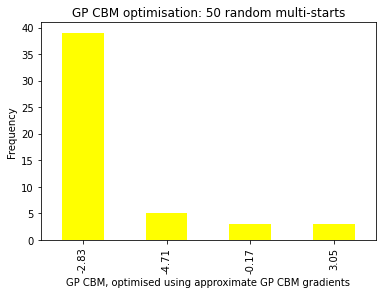

In [22]:
ax = gp_13_50rms.plot.bar(title="GP CBM optimisation: 50 random multi-starts", xlabel="GP CBM, optimised using approximate GP CBM gradients", ylabel="Frequency", color="yellow")


In [23]:
stp_13_50rms = pd.Series(np.round(stp_13_50rms.f_best, 2)).value_counts(sort=True)
stp_13_50rms_df = pd.DataFrame({'Frequency':stp_13_50rms.values,'STP CBM':stp_13_50rms.index})
stp_13_50rms_df


,Frequency,STP CBM
0,39,-2.83
1,5,-4.71
2,3,-0.17
3,3,3.05


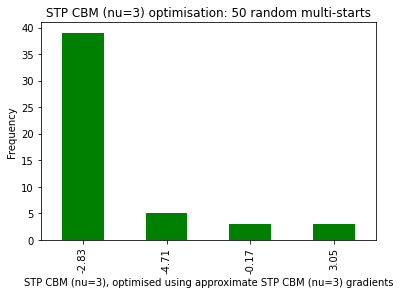

In [24]:
ax = stp_13_50rms.plot.bar(title="STP CBM (nu=3) optimisation: 50 random multi-starts", xlabel="STP CBM (nu=3), optimised using approximate STP CBM (nu=3) gradients", ylabel="Frequency", color="green")


In [25]:
n_start = 100


In [26]:
### APPROXIMATE GP CBM GRADIENTS: 100 random-multi starts (i.e. 100 rms)

np.random.seed(run_num_13)
surrogate_gp_13_100rms = GaussianProcess(cov_func, optimize=hyperOpt)

gp_13_100rms = GPGO_multi(surrogate_gp_13_100rms, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_13_100rms.run(max_iter = 1, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. GP CBM
init	 [ 2.4993217  -2.36212902]	 1312.0597023727128	 25.917758071459016	    
init	 [2.91850679 4.19174278]	 48757.43948599124	 25.917758071459016	    
init	 [ 4.25341003 -0.41895677]	 25.917758071459016	 25.917758071459016	    
init	 [0.98138216 2.47973863]	 337.8750512678324	 25.917758071459016	    
init	 [1.2745201  1.99816407]	 177.1374160884886	 25.917758071459016	    
1	 [0.68616841 0.87186966]	 12.072275435399341	 12.072275435399341	 -4.712002818735367


In [27]:
### APPROXIMATE STP CBM GRADIENTS: 100 random-multi starts (i.e. 100 rms)

np.random.seed(run_num_13)
surrogate_stp_13_100rms = GaussianProcess(cov_func, optimize=hyperOpt)

stp_13_100rms = GPGO_multi(surrogate_stp_13_100rms, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
stp_13_100rms.run(max_iter = 1, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. GP CBM
init	 [ 2.4993217  -2.36212902]	 1312.0597023727128	 25.917758071459016	    
init	 [2.91850679 4.19174278]	 48757.43948599124	 25.917758071459016	    
init	 [ 4.25341003 -0.41895677]	 25.917758071459016	 25.917758071459016	    
init	 [0.98138216 2.47973863]	 337.8750512678324	 25.917758071459016	    
init	 [1.2745201  1.99816407]	 177.1374160884886	 25.917758071459016	    
1	 [0.68616841 0.87186966]	 12.072275435399341	 12.072275435399341	 -4.712002818735367


In [28]:
gp_13_100rms = pd.Series(np.round(gp_13_100rms.f_best, 2)).value_counts(sort=True)
gp_13_100rms_df = pd.DataFrame({'Frequency':gp_13_100rms.values,'GP CBM':gp_13_100rms.index})
gp_13_100rms_df


,Frequency,GP CBM
0,77,-2.83
1,13,-0.17
2,7,-4.71
3,3,3.05


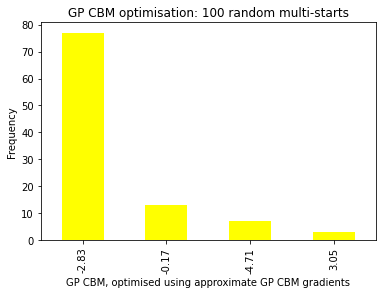

In [29]:
ax = gp_13_100rms.plot.bar(title="GP CBM optimisation: 100 random multi-starts", xlabel="GP CBM, optimised using approximate GP CBM gradients", ylabel="Frequency", color="yellow")


In [30]:
stp_13_100rms = pd.Series(np.round(stp_13_100rms.f_best, 2)).value_counts(sort=True)
stp_13_100rms_df = pd.DataFrame({'Frequency':stp_13_100rms.values,'STP CBM':stp_13_100rms.index})
stp_13_100rms_df


,Frequency,STP CBM
0,77,-2.83
1,13,-0.17
2,7,-4.71
3,3,3.05


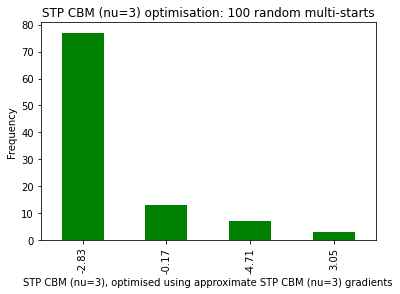

In [31]:
ax = stp_13_100rms.plot.bar(title="STP CBM (nu=3) optimisation: 100 random multi-starts", xlabel="STP CBM (nu=3), optimised using approximate STP CBM (nu=3) gradients", ylabel="Frequency", color="green")


In [32]:
print(gp_13_20rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-2.83 &  16 \\
-0.17 &   2 \\
-4.71 &   2 \\
\bottomrule
\end{tabular}



In [33]:
print(stp_13_20rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-28162.15 &  12 \\
-28167.59 &   5 \\
-28152.46 &   2 \\
-28162.92 &   1 \\
\bottomrule
\end{tabular}



In [34]:
print(gp_13_50rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-2.83 &  39 \\
-4.71 &   5 \\
-0.17 &   3 \\
 3.05 &   3 \\
\bottomrule
\end{tabular}



In [35]:
print(stp_13_50rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-2.83 &  39 \\
-4.71 &   5 \\
-0.17 &   3 \\
 3.05 &   3 \\
\bottomrule
\end{tabular}



In [36]:
print(gp_13_100rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-2.83 &  77 \\
-0.17 &  13 \\
-4.71 &   7 \\
 3.05 &   3 \\
\bottomrule
\end{tabular}



In [37]:
print(stp_13_100rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-2.83 &  77 \\
-0.17 &  13 \\
-4.71 &   7 \\
 3.05 &   3 \\
\bottomrule
\end{tabular}



In [38]:
### Synthetic function for testing i.e. y = sine(x):

def objfunc(x1_training):                       # Define synthetic function
        return  operator * np.sin(x1_training)
                          
def objfunc_der(x1_training):                   # Define synthetic function's true first-order derivative i.e. gradient
        return  operator * np.cos(x1_training)

# Constraints:
lb = 0                                          # Lower-bound of synthetic function's input x vector (1-D)
ub = 2 * np.pi                                  # Upper-bound of synthetic function's input x vector (1-D)
    
# Input array dimension(s):                     # 1-D problem
dim = 1

# 1-D inputs' parameter bounds:                 # 1-D bounds' parameter object
param = {'x1_training': ('cont', [lb, ub])}

# True y bounds:
operator = 1                                  # Can toggle between seeking the synthetic's minimum versus maximum
y_global_orig = 1                             # Maximum for y = sine(x)

# Test data:
x1_test = np.linspace(lb, ub, n_test)         # Define test data object
x_test = np.column_stack((x1_test)).T         # Transposed for algebraic reasons

seed = 1                                      # Re-producability term for randomized initialization


In [39]:
### Plot Gaussian surrogate + acquisition: y = sine(x):

def plot_Gaussian(gpgo, param, new=True):
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    x_test_h = x_test + eps
    y_hat, y_var = gpgo.GP.predict(x_test, return_std=True)
    std = np.sqrt(y_var)
    l, u = y_hat - 1.96 * std, y_hat + 1.96 * std
    colours = ['Post', 'Random']
    a = np.array([gpgo._acqWrapper(np.atleast_1d(x))[0] for x in x_test]).flatten()
    if new:
        fig = plt.figure(figsize=(10,7))
        r = fig.add_subplot(2, 1, 1)
        plt.scatter(gpgo.GP.X, gpgo.GP.y, marker ='D', color = 'Red', label='Function evaluation point: ($\mathbf{x}$, $y$)')
        plt.scatter(gpgo.X, gpgo.y, marker ='D', color = 'Green', label='Random-initialisation point: ($\mathbf{x}$, $y$)')
        plt.ylim(-2, 2)
        plt.xlim(0,2 * np.pi)
        plt.plot(x_test.flatten(), operator * objfunc(x_test.flatten()), color = 'Yellow', label='Objective function: $y$ = sin($\mathbf{x}$)')
        plt.plot(x_test.flatten(), y_hat, color = 'Orange', ls = '--', label='GP posterior mean: $\hat{y} = \mu_{GP}(\mathbf{x})$')
        plt.fill_between(x_test.flatten(), l, u, alpha=0.2, label='95% Confidence Interval for $\hat{\mu}_{GP}(\mathbf{x})$')
        plt.axvline(x=x_test[np.argmin(a)], color='Brown', ls = '--', label='GP CBM: arg min $\mathbf{x}$')
        ###plt.legend(loc=0)
        title = 'GP CBM, optimised with approximate GP CBM gradients'
        r.set_title(title, weight = 'bold')
        plt.xlabel("$\mathbf{x}$")
        plt.ylabel("sin($\mathbf{x}$), $\hat{\mu}_{GP}(\mathbf{x})$")
        r = fig.add_subplot(2, 1, 2)
        plt.plot(x_test, a, color='Purple', label='GP CBM$(\mathbf{x})$')
        plt.axvline(x=x_test[np.argmin(a)], color='Brown', ls = '--', label='GP CBM: arg min $\mathbf{x}$')
        plt.legend(loc=0)
        plt.xlim(0,2 * np.pi)
        plt.xlabel("$\mathbf{x}$")
        plt.ylabel("GP CBM$(\mathbf{x})$")
        plt.show()
        

In [40]:
### Plot Student's-t surrogate + acquisition: y = sine(x):

def plot_Student(gpgo, param, new=True):
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    x_test_h = x_test + eps
    y_hat, y_var = gpgo.GP.predict(x_test, return_std=True)
    std = np.sqrt(y_var)
    l, u = y_hat - 3.182 * std, y_hat + 3.182 * std # t-score, 3 DF, 95% confidence (two-tail)
    a = np.array([gpgo._acqWrapper(np.atleast_1d(x))[0] for x in x_test]).flatten()
    colours = ['Post', 'Random']
    if new:
        fig = plt.figure(figsize=(10,7))
        r = fig.add_subplot(2, 1, 1)
        plt.scatter(gpgo.GP.X, gpgo.GP.y, marker ='D', color = 'Red', label='Function evaluation point: ($\mathbf{x}$, $y$)')
        plt.scatter(gpgo.X, gpgo.y, marker ='D', color = 'Green', label='Random-initialisation point: ($\mathbf{x}$, $y$)')
        plt.ylim(-3, 3)
        plt.xlim(0,2 * np.pi)
        plt.plot(x_test.flatten(), operator * objfunc(x_test.flatten()), color = 'Yellow', label='Objective function: $y$ = sin($\mathbf{x}$)')
        plt.plot(x_test.flatten(), y_hat, color = 'Orange', ls = '--', label='STP (nu=3) posterior mean: $\hat{y} = \mu_{STP}(\mathbf{x})$')
        plt.fill_between(x_test.flatten(), l, u, alpha=0.2, label='95% Confidence Interval for $\hat{\mu}_{STP}(\mathbf{x})$')
        plt.axvline(x=x_test[np.argmin(a)], color='Brown', label='STP (nu=3) CBM: arg min $\mathbf{x}$')
        ###plt.legend(loc=0)
        title = 'STP (nu=3) CBM, optimised with approximate STP (nu=3) CBM gradients'
        r.set_title(title, weight = 'bold')
        plt.xlabel("$\mathbf{x}$")
        plt.ylabel("sin($\mathbf{x}$), $\hat{\mu}_{STP}(\mathbf{x})$")
        r = fig.add_subplot(2, 1, 2)
        plt.plot(x_test, a, color='Purple', ls = '--', label='STP (nu=3) CBM$(\mathbf{x})$')
        plt.axvline(x=x_test[np.argmin(a)], color='Brown', label='STP (nu=3) CBM: arg min $\mathbf{x}$')
        plt.legend(loc=4)
        plt.xlim(0,2 * np.pi)
        plt.xlabel("$\mathbf{x}$")
        plt.ylabel("STP (nu=3) CBM$(\mathbf{x})$")
        plt.show()


In [41]:
### Approximate GP CBM gradients: 1st function evaluation

n_init = 3
iters = 1

np.random.seed(seed)
surrogate_approx_gp1 = GaussianProcess(cov_func, optimize=hyperOpt)

approx_gp1 = GPGO_multi(surrogate_approx_gp1, Acquisition_new(util_gp), objfunc, param)
approx_gp1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. GP CBM
init	 [2.62022653]	 -0.4980652197092493	 -0.4980652197092493	    
init	 [4.52593227]	 0.9826672516685445	 -0.4980652197092493	    
init	 [0.00071864]	 -0.0007186381099970609	 -0.4980652197092493	    
1  	 [2.62022666]	 -0.49806511024605266	 -0.4980652197092493	 -0.025066115687982535


In [42]:
### Approximate STP CBM gradients: 1st function evaluation

np.random.seed(seed)
surrogate_approx_stp1 = tStudentProcess(cov_func, optimize=hyperOpt, nu=df)

approx_stp1 = GPGO_multi_STP(surrogate_approx_stp1, Acquisition_new(util_stp), objfunc, param)
approx_stp1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. STP CBM (nu=3)
init	 [2.62022653]	 -0.4980652197092493	 -0.4980652197092493	    
init	 [4.52593227]	 0.9826672516685445	 -0.4980652197092493	    
init	 [0.00071864]	 -0.0007186381099970609	 -0.4980652197092493	    
1	 [2.37396545]	 -0.6944298255404477	 -0.6944298255404477	 -0.028205282647350272


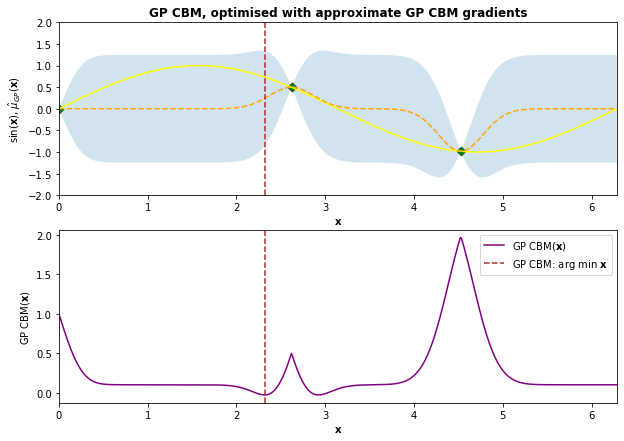

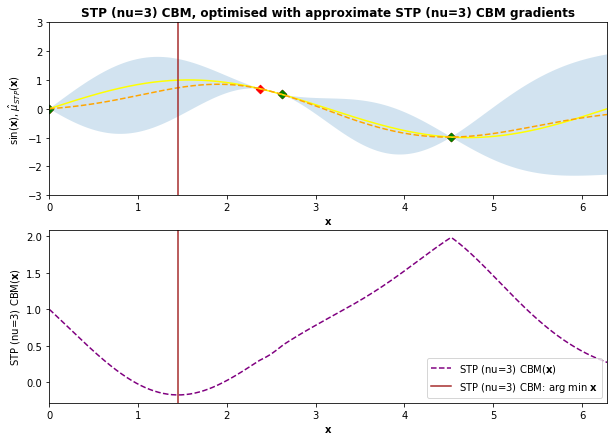

In [43]:
plot_Gaussian(approx_gp1, param, new=True)
plot_Student(approx_stp1, param, new=True)


In [44]:
### Approximate GP CBM gradients: 2nd function evaluation

np.random.seed(seed)
surrogate_approx_gp2 = GaussianProcess(cov_func, optimize=hyperOpt)

approx_gp2 = GPGO_multi(surrogate_approx_gp2, Acquisition_new(util_gp), objfunc, param)
approx_gp2.run(init_evals=n_init, max_iter=iters+1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. GP CBM
init	 [2.62022653]	 -0.4980652197092493	 -0.4980652197092493	    
init	 [4.52593227]	 0.9826672516685445	 -0.4980652197092493	    
init	 [0.00071864]	 -0.0007186381099970609	 -0.4980652197092493	    
1  	 [2.62022666]	 -0.49806511024605266	 -0.4980652197092493	 -0.025066115687982535
2	 [2.31705147]	 -0.7342363692921671	 -0.7342363692921671	 -0.028205927285924175


In [45]:
### Approximate STP CBM gradients: 2nd function evaluation

np.random.seed(seed)
surrogate_approx_stp2 = tStudentProcess(cov_func, optimize=hyperOpt, nu=df)

approx_stp2 = GPGO_multi_STP(surrogate_approx_stp2, Acquisition_new(util_stp), objfunc, param)
approx_stp2.run(init_evals=n_init, max_iter=iters+1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. STP CBM (nu=3)
init	 [2.62022653]	 -0.4980652197092493	 -0.4980652197092493	    
init	 [4.52593227]	 0.9826672516685445	 -0.4980652197092493	    
init	 [0.00071864]	 -0.0007186381099970609	 -0.4980652197092493	    
1	 [2.37396545]	 -0.6944298255404477	 -0.6944298255404477	 -0.028205282647350272
2	 [1.45203798]	 -0.9929565120974798	 -0.9929565120974798	 -0.17290501830978694
